# Step 1 - Problem & Solution

***Problem:*** Businesses such as potential restaurant owners want to explore and compare foot traffic at locations they are interested in and compare their recent daily pedestrian volume at different times and different days of the week. Relying on this information, they can choose the best area to place their business workplace.

***Solution***:

We will take the specific area that a business wants to analyze foot traffic as the input, then we will create a live Pedestrian Map and mark the business area. Next, we will show some near pedestrian sensors in a specific radius such as 200 meters. The business can choose multiple sensors. After that, A window will appear and compare the pedestrian data of the current date and 4-weeks average data by showing a line chart that visualizes pedestrian volume at different times of the day of those sensors.

# Step 2 - Access and Collect Data

To understand the Pedestrian Count data in Melbourne, we have opted to use the City of Melbourne's [Pedestrian Counting System - Past Hour (counts per minute)](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Past-Hour-counts-per-mi/d6mv-s43h) [1].

This dataset contains minute-by-minute directional pedestrian counts from pedestrian sensor devices located across the city for the last hour. The data is updated every 15 minutes and can be used to determine variations in pedestrian activity throughout the day [2].

We also use the data set of the City of Melbourne's [Sensor Locations](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234) to extract the location of these sensors for locating on a pedestrian traffic map.

Because we aim to make the decision based on the latest data and create a map from these data, we will create a function to extract automatically, transform and load the data every 15 minutes. Firstly, we will do ETL (Extraction, Transformation, Loading) for Sensor Locations and Pedestrian Counting System - Past Hour (counts per minute). We then merge these datasets.

***Note:*** We use the package ***sodapy*** to extract from Melbourne Open Data directly. This package is a python client for the Socrata Open Data API [3]. To extract the data from Melbourne Open Data, you must have a dataset id. It can be found as follows:

<img src="images/data_api.png">


In [1]:
from sodapy import Socrata
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')



##function to get Sensor Location Data
def sensor_location():
    client = Socrata('data.melbourne.vic.gov.au', None)
    sensor_location_data_id = "h57g-5234"
    results = client.get(sensor_location_data_id)
    df = pd.DataFrame.from_records(results)
    sensor_location = df[["sensor_id", "sensor_description", "latitude", "longitude"]]
    sensor_location.columns = ["Sensor ID", "Sensor Description", "lat", "lon"]
    sensor_location["lat"] = sensor_location["lat"].apply(lambda x: float(x))
    sensor_location["lon"] = sensor_location["lon"].apply(lambda x: float(x))
    return sensor_location

##function to get the City of Melbourne's Pedestrian Counting System - Past Hour (counts per minute) 
def fifty_minute_count(location):
    #Extract data
    client = Socrata('data.melbourne.vic.gov.au', None)
    fifty_minute_count_data_id = "d6mv-s43h"
    results = client.get(fifty_minute_count_data_id)
    df = pd.DataFrame.from_records(results)
    df = df[["date_time", "sensor_id","total_of_directions"]]
    
    #Show the latest update
    df.columns = ["DateTime", "Sensor ID", "Count"]
    weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
    }
    times = df["DateTime"]
    last_time = times.sort_values(ascending=False).iloc[1].split("T")
    weekday = time.strptime(last_time[0],"%Y-%m-%d").tm_wday
    print(f"The latest data was updated on {weekdays[weekday]} {last_time[0]} at {last_time[1].split('.')[0] } at https://data.melbourne.vic.gov.au")
    
    #Tranfrom data
    df["Count"] = pd.to_numeric(df["Count"])
    counting = df[["Sensor ID", "Count"]].groupby(["Sensor ID"]).sum()
    counting.reset_index(level=0, inplace=True)
    location["Sensor ID"] = location["Sensor ID"].apply(lambda x: str(x))
    
    #Merge 2 dataset
    counting = pd.merge(counting, location, on='Sensor ID', how='inner')
    counting["Count"] = counting["Count"].apply(lambda x: float(x))
    return counting

#ETL Sensor Location
location_data = sensor_location()
# Pedestrian Counting System - Past Hour (counts per minute) and merge with Sensor Location
counting_data = fifty_minute_count(location_data)
#Show 5 first columns
counting_data.head(5)


The latest data was updated on Monday 2021-11-29 at 17:26:00 at https://data.melbourne.vic.gov.au


,Sensor ID,Count,Sensor Description,lat,lon
0,1,611.0,Bourke Street Mall (North),-37.813494,144.965153
1,10,7.0,Victoria Point,-37.818765,144.947105
2,11,28.0,Waterfront City,-37.815650,144.939707
3,12,65.0,New Quay,-37.814580,144.942924
4,14,128.0,Sandridge Bridge,-37.820112,144.962919


| Columns | Description | Type |
| --- | --- | --- |
| Sensor ID | Unique reading ID | Categorical |
| Count | Hourly sum of Pedestrians | Numerical |
| Sensor Description | A description of where the sensor is located | Categorical |
| Lat | Latitude of each sensor | Numerical |
| Lon | Longitude of each sensor | Numerical |

To help the bussiness a comparison of diferent of 2 different sensors, we give them a libe bar chart that compare the pedestrian amount of different hours of today and 4-weeek average amount. We need to crawl the data form http://www.pedestrian.melbourne.vic.gov.au.

***Note*** Because we cannot use ***Sodapy*** to crawl the data from this website, We use another package ***Selenium*** to extract the data [6].

<img src="images/pedestrian_hourly.png">


In [2]:
#Set up Selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
from datetime import date
import numpy as np
import csv
from csv import reader
import matplotlib.pyplot as plt
import os.path
if not os.path.isfile("chromedriver"):
    !wget "https://chromedriver.storage.googleapis.com/94.0.4606.41/chromedriver_linux64.zip"
    !unzip chromedriver_linux64.zip

chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : "/home/parker/Melbourne_Pedestrian_Data/data/"}
chromeOptions.add_experimental_option("prefs",prefs)

def daily_monthly_data():
    #Crawl data
    today = date.today()
    today = today.strftime("%d-%m-%Y")
    file_name = f"COM_24PM_{today}.csv"
    if os.path.exists("data/" + file_name):
        os.remove("data/" + file_name)
    driver = webdriver.Chrome(executable_path='./chromedriver', options=chromeOptions)
    driver.get("http://www.pedestrian.melbourne.vic.gov.au/")
    driver.find_element_by_xpath(f'//*[@id="dropdown-size-small"]').click()
    sleep(2)
    driver.find_element_by_xpath(f'/html/body/div/div/div[5]/div[2]/div/ul/li/a').click()
    sleep(5)
    #Cleaning data
    with open("data/" + file_name, 'r') as read_obj:
        csv_reader = reader(read_obj)
        daily_data = {}
        monthly_data = {}
        yearly_data = {}
        i = 0
        for row in csv_reader:
            if i in range(9, 87):
                daily_data[row[0]] =  row[1:]
            elif i in range(91,169):
                monthly_data[row[0]] =  row[1:]
            i+=1
        for sensor in daily_data:
            if len(daily_data[sensor]) == 0:
                daily_data[sensor] = [np.nan]*24
        for sensor in monthly_data:
            if len(monthly_data[sensor]) == 0:
                monthly_data[sensor] = [np.nan]*24
    #Return daily data and monthly data of sensors
    daily_data = pd.DataFrame(daily_data)
    monthly_data = pd.DataFrame(monthly_data)
    daily_data = daily_data.replace("N/A", np.nan)
    monthly_data = monthly_data.replace("N/A", np.nan)
    for column in daily_data.columns:
        daily_data[column] = pd.to_numeric(daily_data[column])
        daily_data = daily_data.replace(0, np.nan)
        monthly_data[column] = pd.to_numeric(monthly_data[column])
    os.remove("data/" + file_name)
    return daily_data, monthly_data
daily_data, monthly_data = daily_monthly_data()

#Rename coloumns of daily and monthly data because some sensors have different names on different datasets. 
columns = {"Collins St (North)": "Collins Street (North)",
          "Lincoln-Swanston (W)":"Lincoln-Swanston (West)",
          "RMIT Bld 80 - 445 Swanston Street": "Building 80 RMIT",
          "Flinders Ln - Degraves St (South)": "Flinders Ln -Degraves St (South)",
          "Flinders Ln - Degraves St (North)": "Flinders Ln -Degraves St (North)",
          "Flinders Ln - Degraves St (Crossing)": "Flinders Ln -Degraves St (Crossing)",
          "Flinders St - ACMI": "Flinders St- ACMI",
          "Spring St - Flinders St (West)": "Spring St- Flinders st (West)",
          "Macaulay Rd - Bellair St": "Macaulay Rd- Bellair St",
          "Harbour Esplanade - Pedestrian Path": "Harbour Esplanade (West) - Pedestrian path",
          "Harbour Esplanade - Bike Path": "Harbour Esplanade (West) - Bike Path",
           "Flinders La-Swanston St (West) Temporary": "Flinders La - Swanston St (West) Temporary",
           "380 Elizabeth St": "Flinders St-Swanston St (West)"
          }
daily_data.rename(columns=columns, inplace=True)
monthly_data.rename(columns=columns, inplace=True)

In [3]:
#Show 5 columns of daily_data (updated every an hour)
daily_data.head()

,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,Southern Cross Station,Victoria Point,...,Errol Street (East),Westwood Place,Flinders St- ACMI,Bourke St - Spencer St (South),Spring St- Flinders st (West),Macaulay Rd- Bellair St,Harbour Esplanade (West) - Pedestrian path,Harbour Esplanade (West) - Bike Path,Flinders St (South),Total
0,72.0,28.0,244.0,140.0,98.0,99.0,11.0,8.0,4.0,5.0,...,2.0,1.0,47.0,9.0,NaN,2.0,9.0,4.0,82.0,3294.0
1,21.0,11.0,163.0,53.0,23.0,38.0,6.0,15.0,9.0,1.0,...,3.0,1.0,7.0,13.0,NaN,NaN,1.0,NaN,27.0,1963.0
2,38.0,17.0,199.0,43.0,45.0,27.0,10.0,2.0,6.0,1.0,...,11.0,NaN,6.0,5.0,NaN,3.0,NaN,3.0,28.0,1352.0
3,33.0,6.0,103.0,28.0,35.0,46.0,4.0,1.0,4.0,NaN,...,NaN,NaN,3.0,5.0,NaN,NaN,2.0,NaN,47.0,1144.0
4,13.0,4.0,64.0,21.0,41.0,23.0,6.0,5.0,1.0,1.0,...,NaN,4.0,6.0,7.0,NaN,NaN,NaN,1.0,33.0,977.0


In [4]:
#Show 5 columns of daily_data (updated every an hour)
monthly_data.head()

,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,Southern Cross Station,Victoria Point,...,Errol Street (East),Westwood Place,Flinders St- ACMI,Bourke St - Spencer St (South),Spring St- Flinders st (West),Macaulay Rd- Bellair St,Harbour Esplanade (West) - Pedestrian path,Harbour Esplanade (West) - Bike Path,Flinders St (South),Total
0,46,36,234,99,101,126,8,9,10,1.0,...,4,3,25,12,4.0,1.0,18,3,79,3034
1,25,22,144,51,60,54,7,5,5,2.0,...,4,2,13,9,4.0,2.0,5,2,53,1829
2,13,15,78,29,46,35,1,1,3,1.0,...,3,4,14,8,NaN,3.0,7,1,22,1201
3,8,24,54,23,36,21,1,5,3,NaN,...,2,2,4,3,1.0,NaN,5,1,21,953
4,10,25,58,32,46,32,6,1,3,1.0,...,1,2,2,4,1.0,1.0,3,2,20,958


# Step 3 - Basic Map Visualization

To give the customer the most direct view, we use ***ipyleaflet*** [4] to create a live Pedestrian Map of Melbourne. This map presents all data of all pedestrian sensors in Melbourne City. this map is update every 15 minutes.

In [5]:
from ipyleaflet import Map, Marker, MarkerCluster, Circle, basemaps
#Make the output space to be larger
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 1000px; }</style>"))

def map_visualization(data):
    locations = []
    for i in range(len(data)):
        row =data.iloc[i]
        location = [Marker(location=(row.lat,row.lon))]*int(row.Count)
        locations += location
        
    m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[-37.8167, 144.967], zoom=15)
    marker_cluster = MarkerCluster(markers=locations)
    m.add_layer(marker_cluster)
    #Make the output map to be larger
    m.layout.width = '100%'
    m.layout.height = '1000px'
    return m
map_visualization(counting_data)

Map(center=[-37.8167, 144.967], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

From the map, we can see that almost the majority of people are concentrated in the center of Melbourne, especial around Swanton Street.

# Step 4 - Basic Trend Visualization

This visualization aims to compare the pedestrian data between 2 sensors. It is a line chart that consists of 2 lines of 2 different sensors at different times of the day. Based on this visualization, we can compare the rush hours and off-peak hours of 2 sensors. Therefore, We can choose the best place for restaurants.

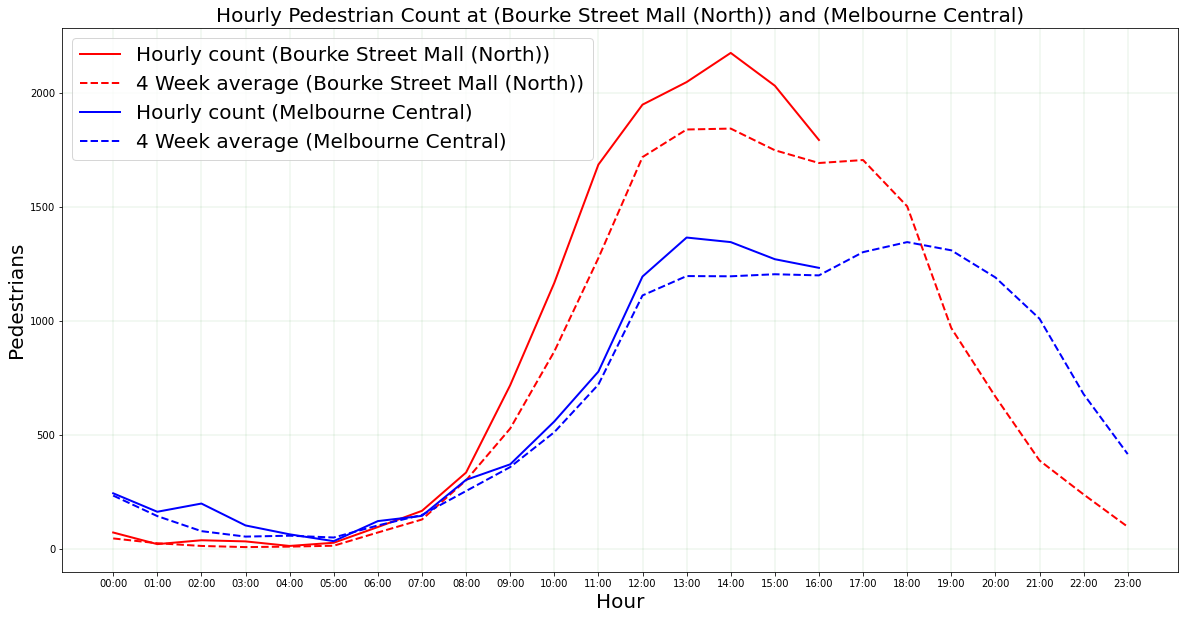

In [6]:
#Function to plot a line chart.
def line_chart(daily_data_sensor_1 , monthly_data_sensor_1, daily_data_sensor_2, monthly_data_sensor_2, sensor_1, sensor_2):
    hours = [f"0{i}:00" for i in range(0, 10)] + [f"{i}:00" for i in range(10, 24)]  
    plt.figure(figsize=(20, 10))
    plt.plot(hours, daily_data_sensor_1,  label = f'Hourly count  ({sensor_1})', linewidth=2, c = "r")
    plt.plot(hours, monthly_data_sensor_1,'--', label = f'4 Week average {sensor_1}))', linewidth=2, c="r")
    plt.plot(hours, daily_data_sensor_2, label = f'Hourly count  ({sensor_2})', linewidth=2, c = "b")
    plt.plot(hours, monthly_data_sensor_2, "--",label = f'4 Week average {sensor_2}))', linewidth=2, c = "b")
    labels = [f"Hourly count ({sensor_1})", f'4 Week average ({sensor_1})', f"Hourly count ({sensor_2})", f'4 Week average ({sensor_2})']
    plt.legend(labels, prop={'size': 20})
    plt.grid(color='g', linestyle='-', linewidth=0.1)
    plt.xticks(hours)
    plt.title(f"Hourly Pedestrian Count at ({sensor_1}) and ({sensor_2})", fontsize=20)
    plt.xlabel(f"Hour", fontsize=20)
    plt.ylabel(f"Pedestrians", fontsize=20)

#Function to filter dataset by Sensor ID
def trend_visualization(sensor_1, sensor_2, daily_data = daily_data, monthly_data =  monthly_data):
    sensor_1 = location_data[location_data["Sensor ID"] == str(sensor_1)]["Sensor Description"].iloc[0]
    sensor_2 = location_data[location_data["Sensor ID"] == str(sensor_2)]["Sensor Description"].iloc[0]
    daily_data_sensor_1 = daily_data[sensor_1]
    monthly_data_sensor_1 = monthly_data[sensor_1]
    daily_data_sensor_2 = daily_data[sensor_2]
    monthly_data_sensor_2 = monthly_data[sensor_2]
    line_chart(daily_data_sensor_1 , monthly_data_sensor_1, daily_data_sensor_2, monthly_data_sensor_2, sensor_1, sensor_2)

#Show line chart of sensor 1 and 4
trend_visualization(1, 3)

Based on this visualization, if we want to open a noon restaurant or Coffee, we should locate our business near from Bourke Street Mall Street. On the other hand, the area, that is near from Melbourne Center, is suitable for a noght business.

# Step 5 - Geographic Filter

It is difficult for people to know their location via Sensor ID. For example, they do not know which sensors are near Flinder Street. Therefore, the above products are unreality to use. We take specific addresses as data input instead of Sensor ID like the above products to resolve this problem.

We aim to create a Geographic Filter that will take ***specific addresses*** such as 100 Flinder Street and create a live map and a live line chart. However, an address may have multiple sensors near it. Therefore, the filter will take another variable called ***Radius***. This value aims to filter all sensors near from addresses within its value. We then take a sum of these different sensors to access the pedestrian data of the address.

To solve this problem, we have 8 steps :

1. Take addesses
2. Use Google API to get the information about Latitude and Longtitude of these addresses
3. Find the distance between these addresses and the sensors
4. Filter sensors are near these addresses
5. Create a live chart
6. Filter daily and monthly data
7. Draw a line chart

In [7]:
import googlemaps
import requests
import json
import numpy as np
import geopy.distance
API_key ='Google API KEY'
gmaps = googlemaps.Client(key=API_key)


#This function takes a address and return the address and it's latitude and longitude
def extract_location(fitler_address_value):
    address_name = f'{fitler_address_value}, Melboune, Victoria, Australia.'
    geocode_result = gmaps.geocode(address_name)
    location = geocode_result[0]["geometry"]["location"]
    return address_name, np.array([location["lat"], location["lng"]])

#This function takes the whole dataset, address, and radius_value (meter)
#and return the data of sensors that are near from the address
def geo_filter_data(dataset, fitler_address_value,  radius_value):
    specific_address  = extract_location(fitler_address_value)
    counting_data_filter = dataset
    counting_data_filter["distance"] =  counting_data_filter[["lat", "lon"]].apply(lambda row: distance(row, specific_address[1]), axis = 1)
    counting_data_filter = counting_data_filter[counting_data_filter["distance"] <= radius_value]
    location = [specific_address[1][0], specific_address[1][1]]
    return counting_data_filter, location

def map_visualization(data, filter_sensors, center, filter_values, radius_value):
    if filter_values == []:
        locations = []
        for i in range(len(data)):
            row =data.iloc[i]
            location = [Marker(location=(row.lat,row.lon))]*int(row.Count)
            locations += location
        m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=15)
        marker_cluster = MarkerCluster(markers=locations)
        m.add_layer(marker_cluster)
        m.layout.width = '100%'
        m.layout.height = '1000px'
        return m
    else:
        m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=list(center), zoom=15)
        locations = []
        for location in filter_sensors:
            sensor_ids = filter_sensors[location]["sensor id"]
            center_i = filter_sensors[location]["location"]
            data_filter= data[data["Sensor ID"].isin(sensor_ids)]
            for i in range(len(data_filter)):
                row =data_filter.iloc[i]
                location_i = [Marker(location=(row.lat,row.lon))]*int(row.Count)
                locations += location_i
                marker = Marker(location=list(center_i), draggable=False)
                circle = Circle(location = list(center_i),weight =1, radius = radius_value, color = "red", fill_color = "#ffffff00")
                m.add_layer(circle)
                m.add_layer(marker)
                
        marker_cluster = MarkerCluster(markers=locations)
        m.add_layer(marker_cluster)
        m.layout.width = '100%'
        m.layout.height = '1000px'
        return m
                
#This function caculate the distance between the address and sensors 
def distance(row, address):
    return geopy.distance.geodesic((row[0], row[1]), (address[0], address[1])).m

#This function plots the line chart
def line_chart(daily_data, monthly_data, locations, fitler_address_value):
    hours = [f"0{i}:00" for i in range(0, 10)] + [f"{i}:00" for i in range(10, 24)]
    plt.figure(figsize=(20, 10))
    #If there are no geo filter value, this function will return a top 3 pedestrian sensor counts
    if fitler_address_value == []:
        labels = []
        title = f"Top 3 Hourly Pedestrian Count Sensors in Melboune, Victoria, Australia"
        colors = ["r", "y", "b"]
        for i, sensor_id in enumerate( locations):
            name = location_data[location_data["Sensor ID"] == sensor_id]["Sensor Description"].iloc[0]
            daily_data_i = list(daily_data[name])
            monthly_data_i = list(monthly_data[name])
            plt.plot(hours, daily_data_i, label = f'Hourly count at {name} today', linewidth=2, c = colors[int(i)])
            plt.plot(hours, monthly_data_i,"--", label = f'One month average at {name}',  linewidth=2, c = colors[int(i)])
            labels.append(f'Hourly count at {name} today')
            labels.append(f'One month average at ({name})')
        plt.legend(labels, prop={'size': 13})
        plt.grid(color='g', linestyle='-', linewidth=0.1)
        plt.xticks(hours)
        plt.title(title, fontsize=20)
        plt.xlabel(f"Hour", fontsize=20)
        plt.ylabel(f"Pedestrians", fontsize=20)
        plt.show()
        
    #If there are geo filter values, this function will return the sums of all sensors around specific addresses
    else:
        labels = []
        title = f"Pedestrian Data Analysis at "
        colors = ["r", "y", "b", "black", "pubble"]
        #For each addrress of input addresses
        for i, location  in enumerate(locations):
            sensor_id = locations[location]["sensor id"]
            sensor_names = []
            #get all sensor's name of each address
            for sensorID in sensor_id:
                name = location_data[location_data["Sensor ID"] == sensorID]["Sensor Description"].iloc[0]
                sensor_names.append(name)
            #Filter daily and monthly data
            filter_daily_data = daily_data[sensor_names]
            filter_monthly_data = monthly_data[sensor_names]
            #Get the sum of all sensor around a address
            filter_daily_data["SUM"] =  filter_daily_data.sum(axis=1).replace(0, np.nan)
            filter_monthly_data["SUM"] =  filter_monthly_data.sum(axis=1)
            #Add daily line and monthly line for each address
            plt.plot(hours, filter_daily_data["SUM"], label = f'Hourly count at {location} today', linewidth=2, c = colors[int(i)])
            plt.plot(hours, filter_monthly_data["SUM"],"--", label = f'One month average at {location}',  linewidth=2, c = colors[int(i)])
            labels.append(f'Hourly count at {location} today')
            labels.append(f'One month average at {location}')
            plt.legend(labels, prop={'size': 13})
        plt.grid(color='g', linestyle='-', linewidth=0.1)
        plt.xticks(hours)
        plt.title(title, fontsize=20)
        plt.xlabel(f"Hour", fontsize=20)
        plt.ylabel(f"Pedestrians", fontsize=20)
        plt.show()

#This is the main part of visualization
def visualization(fitler_address_values, live_counting_data = counting_data,radius_value = 200):
    if fitler_address_values == []:
        center = [ -37.8167, 144.967]
        filter_sensors = None
        m = map_visualization(counting_data ,filter_sensors, center, fitler_address_values, radius_value)
        top_3_sensor_IDs = list(live_counting_data.sort_values(by=['Count'], ascending=False)["Sensor ID"])[:3]
        line_chart(daily_data, monthly_data, top_3_sensor_IDs, fitler_address_values)
        return m
    else:
        centers = []
        locations = {}
        for address in fitler_address_values:
            data_filter,lat_long = geo_filter_data(live_counting_data,address,  radius_value)
            sensor_id = list(data_filter["Sensor ID"])
            locations[address] = {}
            locations[address]["sensor id"] = sensor_id
            locations[address]["location"] = lat_long
            centers.append(lat_long)
        center = np.mean(centers, axis=0)
        m = map_visualization(live_counting_data,locations, center, fitler_address_values, radius_value)
        line_chart(daily_data, monthly_data, locations, fitler_address_values)
        return m

We try to visualize PDA without address input. The function will return a live pedestrian traffic map in Melbourne and a line chart showing the three busiest pedestrian sensors.

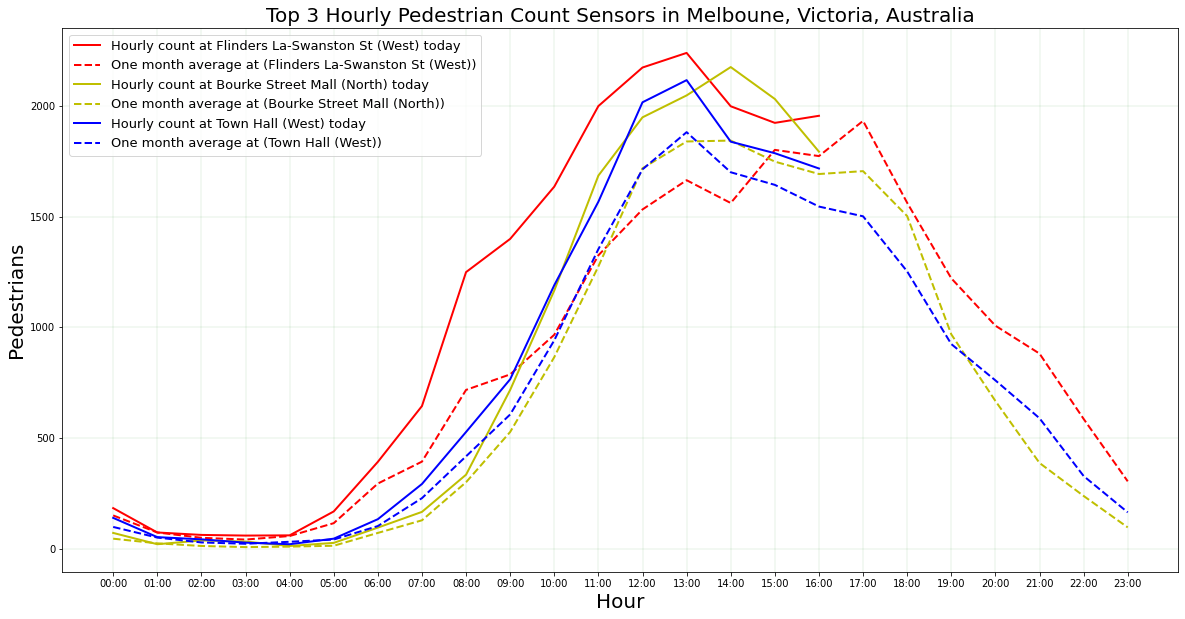

Map(center=[-37.8167, 144.967], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [8]:
display(HTML("<style>div.output_scroll { height: 1600px; }</style>"))
fitler_address_values = []
visualization(fitler_address_values , live_counting_data = counting_data,radius_value = 200)

We now analyze PDA at 3 locations: Flinder Station, southcross station and melbourne central station.

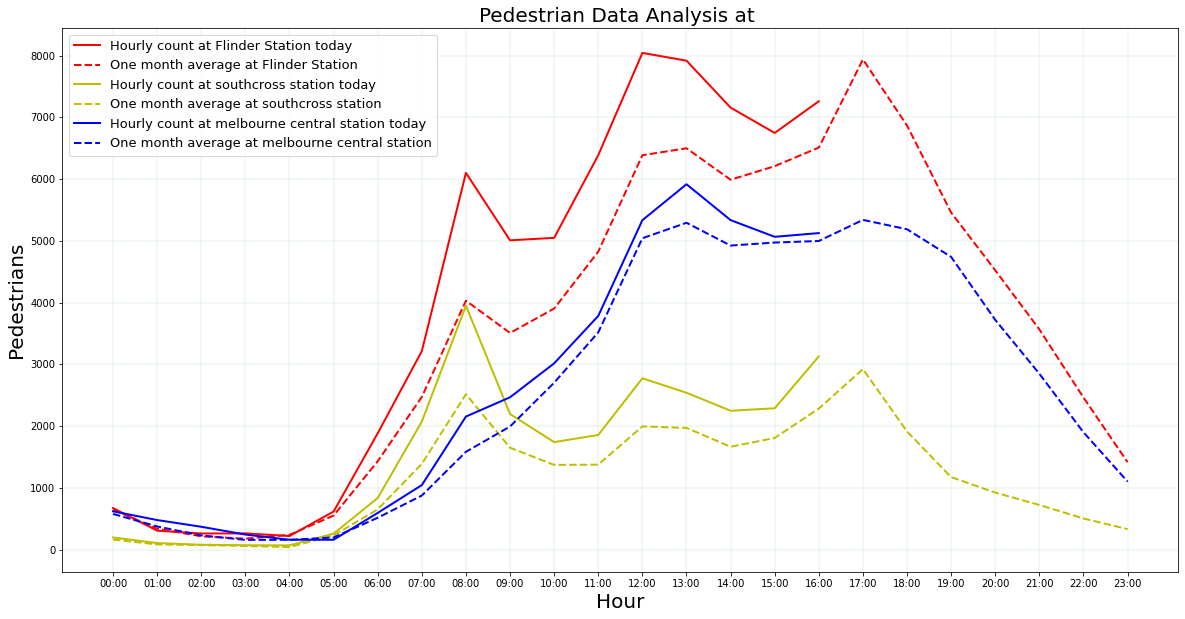

Map(center=[-37.81569579999999, 144.96082083333332], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [9]:
display(HTML("<style>div.output_scroll { height: 1600px; }</style>"))
fitler_address_values = ["Flinder Station", "southcross station", "melbourne central station"]
visualization(fitler_address_values, live_counting_data = counting_data,radius_value = 300)

We now even analyze PDA at 4 locations: 100 Litte Collin Street, 50 Collin Sreet, 10 elizabeth street, and 10 Swanston Street.

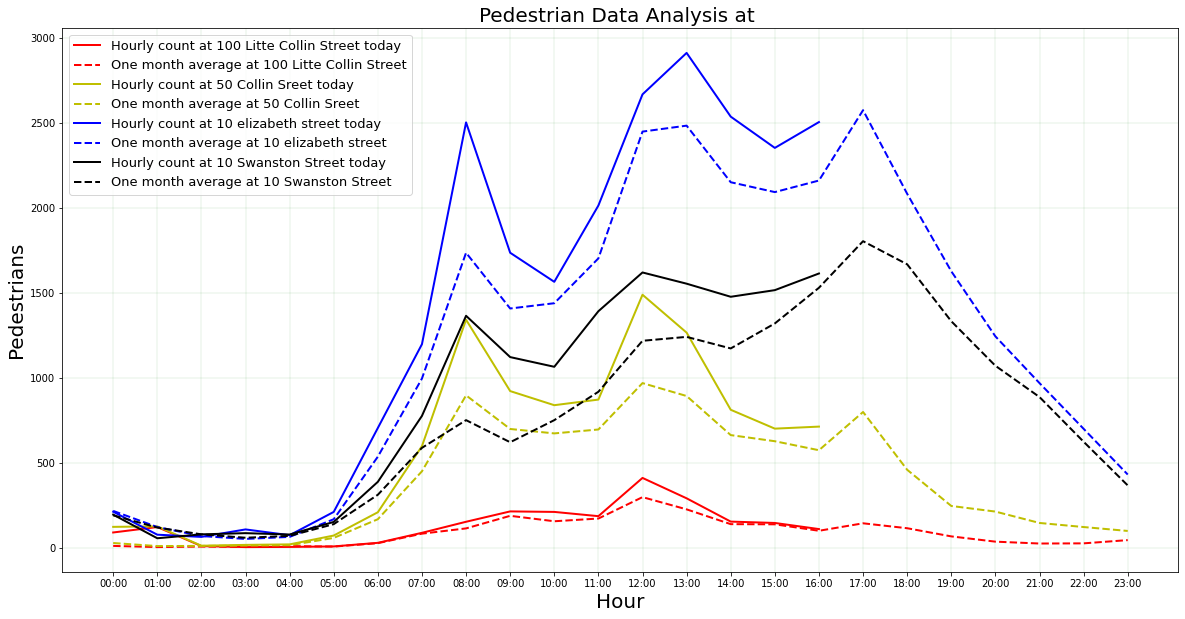

Map(center=[-37.8157371, 144.968871025], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

In [10]:
display(HTML("<style>div.output_scroll { height: 1600px; }</style>"))
fitler_address_values = ["100 Litte Collin Street", "50 Collin Sreet", "10 elizabeth street", "10 Swanston Street"]
visualization(fitler_address_values, live_counting_data = counting_data,radius_value = 200)

In [11]:
!jupyter nbconvert --to html 3_1_4_Deep_PDA_use_case.ipynb

[NbConvertApp] Converting notebook 3_1_4_Deep_PDA_use_case.ipynb to html
[NbConvertApp] Writing 1000639 bytes to 3_1_4_Deep_PDA_use_case.html


# Reference

1: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp

2: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234

3: https://pypi.org/project/sodapy/#:~:text=sodapy%20is%20a%20python%20client%20for%20the%20Socrata%20Open%20Data%20API.

4: https://ipyleaflet.readthedocs.io/en/latest/

5: https://pypi.org/project/selenium/